In [79]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification, make_multilabel_classification
import pandas as pd

In [711]:
data = make_blobs(2000,10,random_state=0,cluster_std=0.1,centers=1,center_box=(-10,10))

<Axes: >

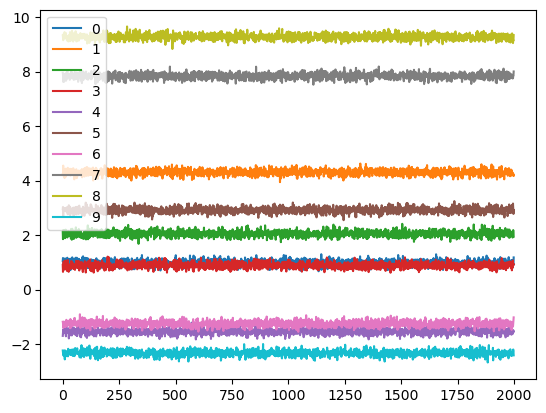

In [715]:
df_samples = pd.DataFrame((data[0]))
df_samples['target'] = data[1][:,np.newaxis]
df_sequential = df_samples.sort_values(by=['target']).reset_index(drop=True).iloc[:,:-1].astype('float32')
df_sequential.plot()

In [659]:
d= 25
mu = np.zeros(d)
#mu[0] = 2

COV = np.eye(d)
COV[0,0] = 3
COV[1,1] = 5
df_sequential = pd.DataFrame(np.vstack((np.random.multivariate_normal(np.zeros(d),np.eye(d),size=500),np.random.multivariate_normal(mu,COV,size=500)))).astype('float32')

df_sequential.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.072668,1.515757,-1.382639,-0.210164,-0.239932,-0.176077,-0.852197,0.497596,-0.164503,-0.249226,0.443991,1.001430,1.012112,1.260486,-0.351843,0.728208,0.320880,-1.071470,-0.955621,0.211979,0.458122,-1.659566,-0.530622,-0.227292,2.026018
1,0.317113,0.244024,1.382637,0.720193,0.273141,-0.621828,0.287549,-2.178261,-0.714978,0.476971,-0.348128,-0.805003,1.072139,-0.887903,-1.776736,1.032849,-0.160564,1.326850,-0.147754,-2.449564,-0.253340,-0.091657,0.628280,0.956440,1.529249
2,1.889871,0.884536,-0.070881,-0.458238,0.196566,-0.294619,-0.463785,-0.925066,-1.613696,1.453194,0.591929,-1.009314,-0.273292,-0.012665,-0.523591,-0.848913,-0.367489,-1.406195,-0.229269,-0.098909,0.201467,1.751084,-1.858341,-0.440256,-0.380842
3,-0.269619,0.146029,1.275823,0.326157,0.066989,1.523247,-0.478373,-0.397587,0.665929,-0.703375,0.183244,-0.293437,0.192024,-0.850479,0.759241,1.437072,-1.726564,0.738959,-0.792614,-1.285759,-0.142432,1.249167,1.104512,-1.833734,-0.857483
4,1.402651,1.220203,0.048215,0.398618,-1.438990,-0.743467,0.257838,0.696068,-0.055026,1.018704,1.201997,0.433756,0.980237,-1.099050,1.927514,-0.280889,0.080078,0.376790,1.036407,-1.110241,-2.646076,0.367248,-0.362175,0.182017,0.677651


In [215]:
np.linalg.norm(df_sequential.iloc[:20],axis=1).max()

0.87084585

In [415]:
def plot_statistic(ax,data,ax2):
    c = 0
    for key in data:
        segment = data[key]
        if c == 0:
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0,label='SWD')
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5,label='Test statstic')
        else: 
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0)
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['lower'],color='blue',lw=1,alpha=0.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],color='blue',lw=1,alpha=0.5)
        ax.fill_between(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],segment['lower'],color='blue',alpha=0.2)
        c+=1

    return ax

  9%|▊         | 166/1951 [00:00<00:03, 467.61it/s]

Change Alarm at iteration 57


 92%|█████████▏| 1787/1951 [00:02<00:00, 783.12it/s]

Change Alarm at iteration 1688
Change Alarm at iteration 1754


100%|██████████| 1951/1951 [00:03<00:00, 607.17it/s]


3.2168195247650146


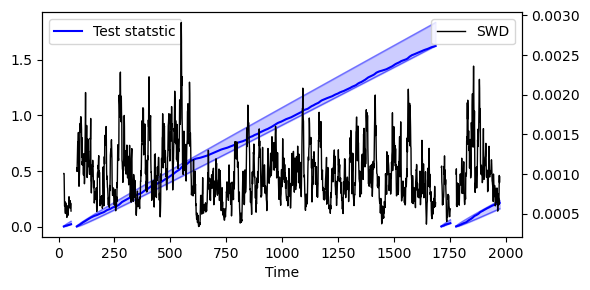

In [718]:
from tqdm import tqdm
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(df_sequential.to_numpy(),LENGHT,split=0.5))
SWDs = []
test_stat = []
calibrated = False
t = 0
skip_count = 0  # To track the number of skipped iterations
segmentation ={}
segments=0
t0=int(LENGHT*0.5)-1
begin = time.time()
loss_segments = []
THETA = sample_theta_torch(df_sequential.to_numpy(), 10000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    # Skip iterations if `skip_count` is active
    if skip_count > 0:
        skip_count -= 1
        continue

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    #THETA = sample_theta_torch(x_ref, 5000)
    #print(THETA.dtype)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).sum(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    SWDs.append(loss.mean())
    test_stat.append(calc_statistic(0.05,x_cur.detach().cpu().numpy()))
    # Calibration phase
    if not calibrated:
        alpha_hat, beta_hat = mom_estimates(loss)
        #print('Calibration at {}'.format(i+LENGHT))
        #print(f"Calibration: alpha={alpha_hat}, beta={beta_hat}")
        calibrated = True
        lower_CI = [0]
        upper_CI = [0]
        cumsum = loss.mean()
        t = 1 
        #last_cal = 0 

    # Monitoring phase
    if calibrated:
        #last_cal += 1 
        l, u = gamma_conf_interval(t, alpha_hat, 1 / beta_hat, 0.90)
        lower_CI.append(l)
        upper_CI.append(u)
        cumsum += loss.mean()
        t += 1

        # Check if a change point is detected
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at iteration {i + int(LENGHT*0.5)}")
            #print(mom_estimates(loss))
            #print(mom_estimates(np.hstack(loss_segments)))
            
            segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
            calibrated = False  # Reset calibration
            cumsum = 0
            t = 0
            skip_count = int(LENGHT*0.5)  # Skip the next 15 iterations
            SWDs = []
            segments+=1
            t0=i+LENGHT
            
        
segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
end = time.time()
print(end-begin)

fig, ax = plt.subplots(figsize=(6,3))
ax2 = ax.twinx()
plot_statistic(ax,segmentation,ax2)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')
fig.tight_layout()

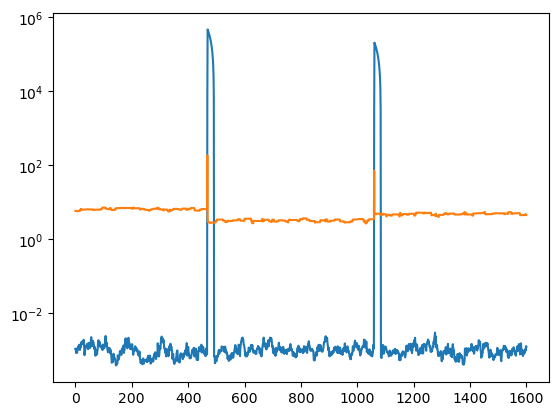

In [674]:
plt.plot([l.mean() for l in loss_segments])
plt.plot(test_stat)
plt.yscale('log')
#plt.axhline(2/np.sqrt(LENGHT/2))
#plt.axhline(2*(LENGHT/2)**(-1/4))
#plt.axhline(22.2)

100%|██████████| 1951/1951 [00:06<00:00, 294.19it/s]


<Axes: >

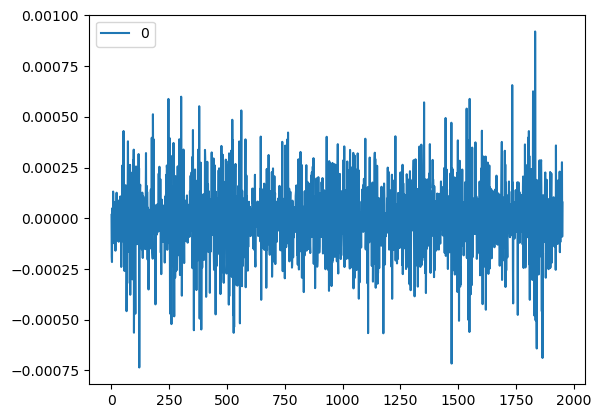

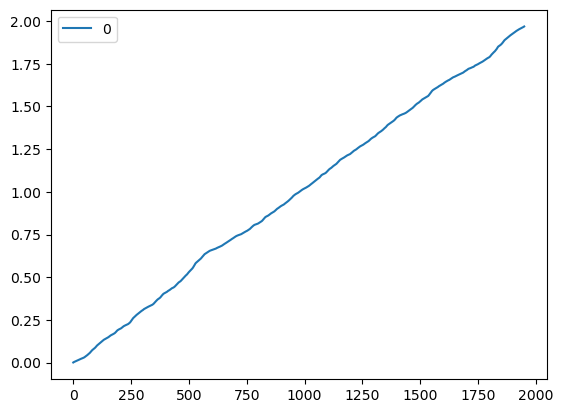

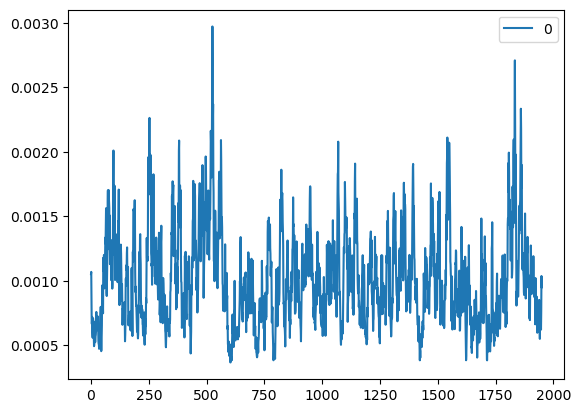

In [719]:
loss_segments = []
alphas= []
betas =[]
test_stat = []
prop5_stat = []
THETA = sample_theta_torch(df_sequential.to_numpy(), 1000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    #THETA = sample_theta_torch(df_sequential.to_numpy(), 10000)

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).sum(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    #a_hat, b_hat = mom_estimates(loss)
    #alphas.append(a_hat)
    #betas.append(b_hat)
    #test_stat.append(calc_statistic(0.05,x_cur.detach().cpu().numpy()))
    #prop5_stat.append(prop5(x_cur.detach().cpu().numpy(),x_ref.detach().cpu().numpy(),p=4,m=5000))
    #SWDs.append(loss.mean())
df = pd.DataFrame([l.mean() for l in loss_segments])
df.diff().plot()
df.cumsum().plot()
df.plot()

In [720]:
def get_var(df):
    a,b = estimate_parameter_CI(df.to_numpy(),0.05)
    return 2*(a[1]/b[0]**2)**0.5

varbound_lower = []
varbound_upper = []
start_ind = 0
skip_count = 0
cps = []
new_seg = []
for i in range(2,len(loss_segments)):
    if skip_count >0:
        skip_count-=1
        varbound_lower.append(0)
        varbound_upper.append(0)

        
        continue
    a,b = estimate_parameter_CI(np.vstack(loss_segments[start_ind:i]),0.05)
    

    bound_var = 2*(a[0]/b[1]**2)**0.5
    if bound_var >= loss_segments[i].mean():

        varbound_lower.append(bound_var)
        varbound_upper.append(2*(a[1]/b[0]**2)**0.5)
    else:
        cps.append(i)
        skip_count = 50
        varbound_lower.append(0)
        varbound_upper.append(0)
        start_ind = i + skip_count
        new_seg.append(start_ind)
        print(start_ind)
    

In [725]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segments(ax, t, cps, new_seg, varbound_lower, varbound_upper, color='red', alpha=0.3):
    """
    Plots segments with changepoints and fills the bounds between varbound_lower and varbound_upper.

    Parameters:
        ax : matplotlib.axes.Axes
            The matplotlib axis object to plot on.
        t : array-like
            The time array corresponding to the data.
        cps : list
            A list of changepoints indices.
        new_seg : list
            A list of starting indices for new segments after waiting 50 values.
        varbound_lower : list or array-like
            The lower bound values for the variable.
        varbound_upper : list or array-like
            The upper bound values for the variable.
        color : str, optional
            The color for the plots and shaded areas (default is 'red').
        alpha : float, optional
            The alpha transparency for the shaded area (default is 0.3).

    Returns:
        None
    """
    # Plot the first segment

    if cps == []:
        ax.plot(t, np.array(varbound_lower), color=color)
        ax.plot(t, np.array(varbound_upper), color=color)
        ax.fill_between(t, 
                    np.array(varbound_lower), 
                    np.array(varbound_upper), 
                    alpha=alpha, color=color)
        return 0 
    ax.plot(t[:cps[0]-2], np.array(varbound_lower)[:cps[0]-2], color=color)
    ax.plot(t[:cps[0]-2], np.array(varbound_upper)[:cps[0]-2], color=color)
    ax.fill_between(t[:cps[0]-2], 
                    np.array(varbound_lower)[:cps[0]-2], 
                    np.array(varbound_upper)[:cps[0]-2], 
                    alpha=alpha, color=color)

    # Loop over subsequent segments
    for i in range(len(new_seg)):
        if i < len(cps) - 1:  # Handle intermediate segments
            start = new_seg[i]
            end = cps[i + 1] - 2
            ax.plot(t[start:end], np.array(varbound_lower)[start:end], color=color)
            ax.plot(t[start:end], np.array(varbound_upper)[start:end], color=color)
            ax.fill_between(t[start:end], 
                            np.array(varbound_lower)[start:end], 
                            np.array(varbound_upper)[start:end], 
                            alpha=alpha, color=color)
        else:  # Handle the last segment
            start = new_seg[i]
            ax.plot(t[start:], np.array(varbound_lower)[start:], color=color)
            ax.plot(t[start:], np.array(varbound_upper)[start:], color=color)
            ax.fill_between(t[start:], 
                            np.array(varbound_lower)[start:], 
                            np.array(varbound_upper)[start:], 
                            alpha=alpha, color=color)


0

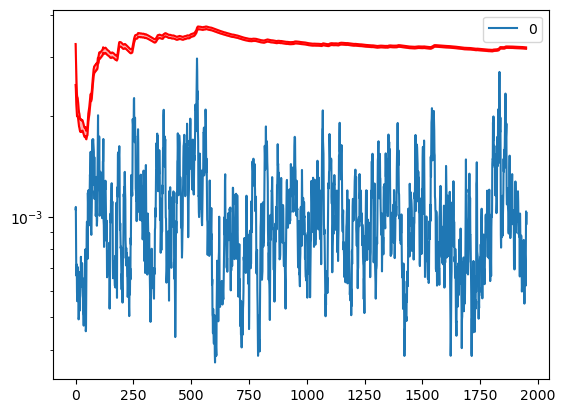

In [726]:
df = pd.DataFrame([l.mean() for l in loss_segments])
fig,ax = plt.subplots()
df.plot(ax=ax)
ax.set_yscale('log')

t = np.array(range(len(varbound_upper)))

plot_segments(ax,t,cps,new_seg,varbound_lower,varbound_upper)

<Axes: >

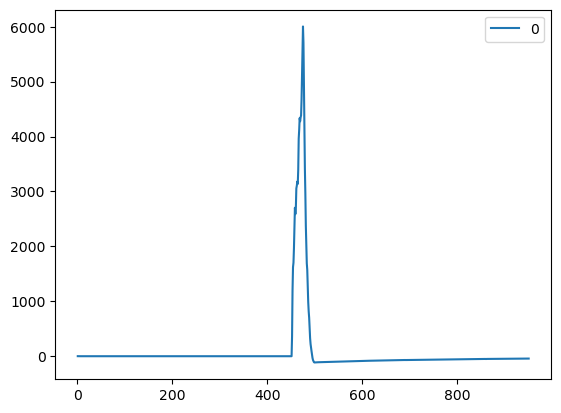

In [568]:
pd.DataFrame(varbound).diff().plot()

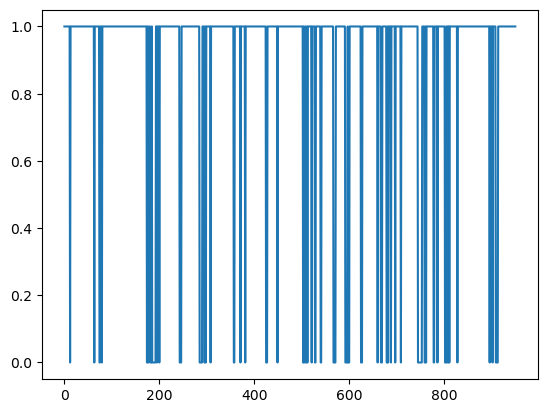

In [553]:
plt.plot(np.array(var_bound) > np.array([l.mean() for l in loss_segments])*1)

In [421]:
diff_mean = 
first = np.linalg.eigvals(df_sequential.iloc[:25].cov()@df_sequential.iloc[:25].cov().T).max()**(4/4)+np.linalg.eigvals(df_sequential.iloc[25:50].cov()@df_sequential.iloc[25:50].cov().T).max()**(4/4)
second = first*np.log(25)/25

first/(np.sqrt(10000*50))+second


(7.073606731086583+0j)

In [503]:
def prop5(x,y,p,m):
    d = x.shape[1]
    c1 =np.linalg.norm(x.mean(axis=0)-y.mean(axis=0))**2*p
    cov_x = np.cov(x.T)
    cov_y = np.cov(y.T)
    opnormx = np.max(np.linalg.eigvals(cov_x@cov_x.T))**(0.5*p/2)
    opnormy = np.max(np.linalg.eigvals(cov_y@cov_y.T))**(0.5*p/2)
    

    first = c1 + opnormx + opnormy
    first = first/np.sqrt(m*d)
    second = (opnormx+ opnormy)/x.shape[0]

    return first + second


prop5(x_cur.detach().cpu().numpy(),x_ref.detach().cpu().numpy(),4,5000)

0.025870166390987614

In [506]:
loss_segments[0].var()

0.11751214

In [471]:
x1 = x_cur.detach().cpu().numpy()

(np.linalg.eigvals(pd.DataFrame(x1).cov()@pd.DataFrame(x1).cov().T).max()**0.5)**(4/2)

29.950256599358465

In [331]:
import numpy as np
from scipy.spatial.distance import pdist

def compute_diameter_multidimensional(sample):
    """
    Computes the diameter of the support of a given multi-dimensional sample set.

    Parameters:
        sample (array-like): A 2D array where each row is a point in n-dimensional space.

    Returns:
        float: The diameter of the support.
    """
    # Ensure the sample is a NumPy array
    sample = np.array(sample)
    
    # Compute all pairwise distances
    distances = pdist(sample, metric='euclidean')
    
    # Find the maximum distance
    diameter = np.max(distances)
    
    return diameter


diam = compute_diameter_multidimensional(df_sequential.iloc[:20])
#compute_diameter_multidimensional(df_sequential.iloc[20:40])

def calc_statistic(alpha,samples):
    n= len(samples)
    diam = compute_diameter_multidimensional(samples)
    return diam*np.sqrt(np.log(2/alpha))/np.sqrt(n)*2*np.sqrt(2/n*samples.var().sum() + np.linalg.norm(samples.mean(axis=1))**2) + 2*n**(-0.5)

In [325]:
diam*np.sqrt(np.log(2/0.05))/np.sqrt(20)*2*np.sqrt(2/20*df_sequential.iloc[:20].var().sum() + np.linalg.norm(df_sequential.iloc[:20].mean(axis=1))**2) + 2*20**(-0.5)

22.109111222600795

In [330]:
calc_statistic(0.05,df_sequential.iloc[:20].to_numpy())

TypeError: calc_statistic() missing 1 required positional argument: 'p'

In [272]:
diam = np.abs(df_sequential.iloc[:20].max().max() - df_sequential.iloc[:20].min().min())
diam#*np.log(2/0.05)/25**0.5

8.111817359924316

In [266]:
diam*np.log(2/0.05)/25**0.5+2*(2/25*(df_sequential.iloc[:25]**2).mean(axis=0).sum())**0.5

9.06024897410649

In [309]:
2*20**(-0.5)

0.4472135954999579